# Lab: Aprendizaje por refuerzo (II)
# 5 - REINFORCE

## Configuración y dependencias

In [1]:
# Declaración de constantes
SLIPPERY = False
TRAINING_EPISODES = 100
NUM_EPISODES = 5
GAMMA = 0.9
T_MAX = 50
LEARNING_RATE = 1.0
LEARNING_RATE_DECAY = 0.99

In [2]:
!pip install gymnasium seaborn numpy

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 965.4/965.4 kB 18.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 89.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 89.8 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 91.5 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 100.4 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 326.2/326.2 kB 101.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 101.7 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 102.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 101.3 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.1/111.1 kB 47.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 509.2/509.2 kB 106

In [3]:
# Imports necesarios
import gymnasium as gym
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from gymnasium import Wrapper

Vamos a crear dos entornos de FrozenLake, los dos con slippery=False. La diferencia es que `env_fast` no cargará la UI, por lo que funcionará más rápido y nos permitirá hacer entrenamientos de muchos episodios.

In [4]:
class CustomFrozenLakeWrapper(Wrapper):
    def __init__(self, env):
        super().__init__(env)
    
    def step(self, action):
        state, reward, is_done, truncated, info = self.env.step(action)
        if is_done and reward < 1:
            reward = -0.2
        if not is_done:
            reward = reward - 0.01
        return state, reward, is_done, truncated, info

env = CustomFrozenLakeWrapper(gym.make("FrozenLake-v1", desc=None, map_name="4x4",
                                       render_mode='human', is_slippery=SLIPPERY))
env_fast = CustomFrozenLakeWrapper(gym.make("FrozenLake-v1", desc=None, map_name="4x4",
                                            is_slippery=SLIPPERY))

Declaramos una función auxiliar para dibujar gráficas de métricas de rendimiento. También copiamos `print_policy` de notebooks anteriores.

In [5]:
def draw_history(history, title):
    window_size = 50
    data = pd.DataFrame({'Episode': range(1, len(history) + 1), title: history})
    data['rolling_avg'] = data[title].rolling(window_size).mean()
    plt.figure(figsize=(10, 6))
    sns.lineplot(x='Episode', y=title, data=data)
    sns.lineplot(x='Episode', y='rolling_avg', data=data)

    plt.title(title + ' Over Episodes')
    plt.xlabel('Episode')
    plt.ylabel(title)
    plt.grid(True)
    plt.tight_layout()

    plt.show()

def print_policy(policy):
    visual_help = {0:'<', 1:'v', 2:'>', 3:'^'}
    policy_arrows = [visual_help[x] for x in policy]
    print(np.array(policy_arrows).reshape([-1, 4]))

## REINFORCE

Vamos a ver brevemente una implementación para el entorno FrozenLake-v1 usando el algoritmo REINFORCE. Recordad que es un algoritmo basado en gradiente de política, por lo que necesitaremos una representación de la política que permita extraer gradientes.

In [6]:
class ReinforceAgent:
    def __init__(self, env, gamma, learning_rate, lr_decay=1, seed=0):
        self.env = env
        self.gamma = gamma # Puntuacion que le damos a las recompensas del estado futuro
        self.learning_rate = learning_rate
        self.lr_decay = lr_decay
        # Objeto que representa la política (J(theta)) como una matriz estados X acciones,
        # con una probabilidad inicial para cada par estado accion igual a: pi(a|s) = 1/|A|
        self.policy_table = np.ones((self.env.observation_space.n, self.env.action_space.n)) / self.env.action_space.n
        np.random.seed(seed)

    def select_action(self, state, training=True):
        action_probabilities = self.policy_table[state]
        if training:
            # Escogemos la acción según el vector de policy_table correspondiente a la acción,
            # con una distribución de probabilidad igual a los valores actuales de este vector
            return np.random.choice(np.arange(self.env.action_space.n), p=action_probabilities)
        else:
            return np.argmax(action_probabilities)

    def update_policy(self, episode):
        states, actions, rewards = episode
        discounted_rewards = np.zeros_like(rewards)
        running_add = 0
        for t in reversed(range(len(rewards))):
            running_add = running_add * self.gamma + rewards[t]
            discounted_rewards[t] = running_add
        loss = -np.sum(np.log(self.policy_table[states, actions]) * discounted_rewards) / len(states)
        policy_logits = np.log(self.policy_table)
        for t in range(len(states)):
            G_t = discounted_rewards[t]
            action_probs = np.exp(policy_logits[states[t]])
            action_probs /= np.sum(action_probs)
            policy_gradient = G_t * (1 - action_probs[actions[t]])
            policy_logits[states[t], actions[t]] += self.learning_rate * policy_gradient
            # Alternativa:
            # policy_gradient = 1.0 / action_probs[actions[t]]
            # policy_logits[states[t], actions[t]] += self.learning_rate * G_t * policy_gradient
        exp_logits = np.exp(policy_logits)
        self.policy_table = exp_logits / np.sum(exp_logits, axis=1, keepdims=True)
        return loss

    def learn_from_episode(self):
        state, _ = self.env.reset()
        episode = []
        done = False
        step = 0
        total_reward = 0
        while not done and step < T_MAX:
            action = self.select_action(state)
            next_state, reward, done, terminated, _ = self.env.step(action)
            episode.append((state, action, reward))
            state = next_state
            total_reward = total_reward + reward
            step = step + 1
        loss = self.update_policy(zip(*episode))
        self.learning_rate = self.learning_rate * self.lr_decay
        return total_reward, loss

    def policy(self):
        policy = np.zeros(env.observation_space.n)
        for s in range(env.observation_space.n):
            action_probabilities = self.policy_table[s]
            policy[s] = np.argmax(action_probabilities)
        return policy, self.policy_table

Para esta implementación sencilla hemos escogido una representación de la J(theta) que se asemeja mucho a una estructura matricial para almacenar la función Q, es decir, una matriz indexada por estados y acciones. Sin embargo, algorítmicamente no estamos haciendo Q-Learning por los siguientes motivos:

* Q-Learning estima los valores de los nodos estado-acción del grafo MDP, sin embargo en esta implementación estamos estimando directamente la probabilidad de cada acción para cada estado. La diferencia es importante porque en el primer caso necesitamos un paso más para derivar la política (i.e. calcular la Q máxima).
* En Q-Learning, estábamos usando el método de diferencias temporales (TD) derivando la función de error de la ecuación de Bellman. En el caso de REINFORCE, estamos usando la fórmula de actualización basada en el gradiente de la política que vimos en teoría.
* En Q-Learning, necésitabamos una política que garantizara exploración. En el caso de REINFORCE, observad que estamos partiendo de una distribución de probabilidad que comienza uniforme y se irá sesgando con el paso de los episodios.
* Q-Learning nos **obliga** a calcular la función Q. En REINFORCE, podríamos haber optado por una representación para la política totalmente diferente, incluso una que no se asemeje en absoluto a esta matriz. Por ejemplo, podríamos estar usando una red neuronal, o incluso representaciones de preferencias entre acciones (Softmax policy) o distribuciones gaussianas (Gaussian policy). Si queréis profundizar en las diferentes maneras de formalizar la política y en qué casos puede funcionar mejor cada una, os recomendamos que leáis el libro de Reinforcement Learning de Sutton&Barto que está listado en la bibliografía de la asignatura.

Vamos a entrenar nuestro agente con el algoritmo REINFORCE. En el output, podréis ver, tras cada episodio (trayectoria), el vector de probabilidades de cada acción para cada estado, que comienzan distribuidas uniformemente (25%). Observad cómo van variando los valores mientras observáis la trayectoria del agente.

**¿Cuáles diríais que son los factores que están influyendo más en la variación de estas probabilidades?** Os puede ser útil revisar el método `update_policy` y relacionarlo con la fórmula de la función de pérdida de REINFORCE vista en el material de teoría.

In [10]:
agent = ReinforceAgent(env_fast, gamma=GAMMA, learning_rate=LEARNING_RATE,
                       lr_decay=LEARNING_RATE_DECAY, seed=8)
rewards = []
losses = []
learning = []
for i in range(TRAINING_EPISODES):
    reward, loss = agent.learn_from_episode()
    policy, policy_table = agent.policy()
    print(policy_table)
    print(f"Last reward: {reward}, last loss: {loss}, new lr: {agent.learning_rate}")
    print_policy(policy)
    print(f"End of iteration [{i + 1}/{TRAINING_EPISODES}]")
    rewards.append(reward)
    losses.append(loss)
    learning.append(agent.learning_rate)

[[0.23743049 0.25246243 0.2159642  0.29414287]
 [0.31453171 0.22848943 0.22848943 0.22848943]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.21767252 0.34698245 0.21767252 0.21767252]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.21308924 0.21308924 0.36073227 0.21308924]
 [0.20790622 0.37628134 0.20790622 0.20790622]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.25       0.25       0.25       0.25      ]
 [0.20204641 0.20204641 0.39386076 0.20204641]
 [0.19542701 0.19542701 0.41371898 0.19542701]
 [0.25       0.25       0.25       0.25      ]]
Last reward: 0.89, last loss: 0.7732374605637055, new lr: 0.99
[['^' '<' '<' '<']
 ['v' '<' '<' '<']
 ['>' 'v' '<' '<']
 ['<' '>' '>' '<']]
End of iteration [1/100]
[[0.26221842 0.27881971 0.20639326 0.25256861]
 [0.32505323 0.20268133 0.23613272 

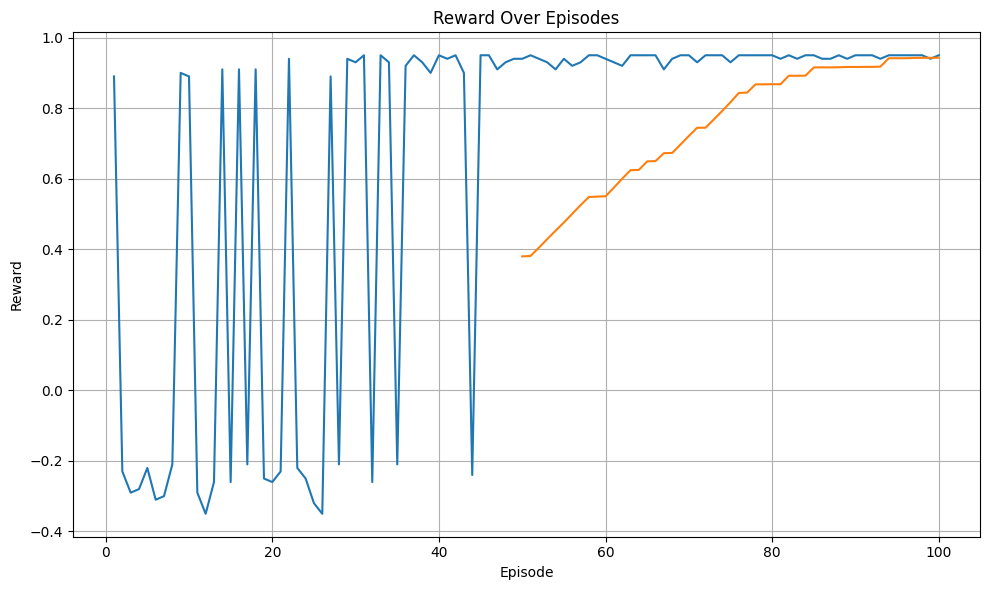

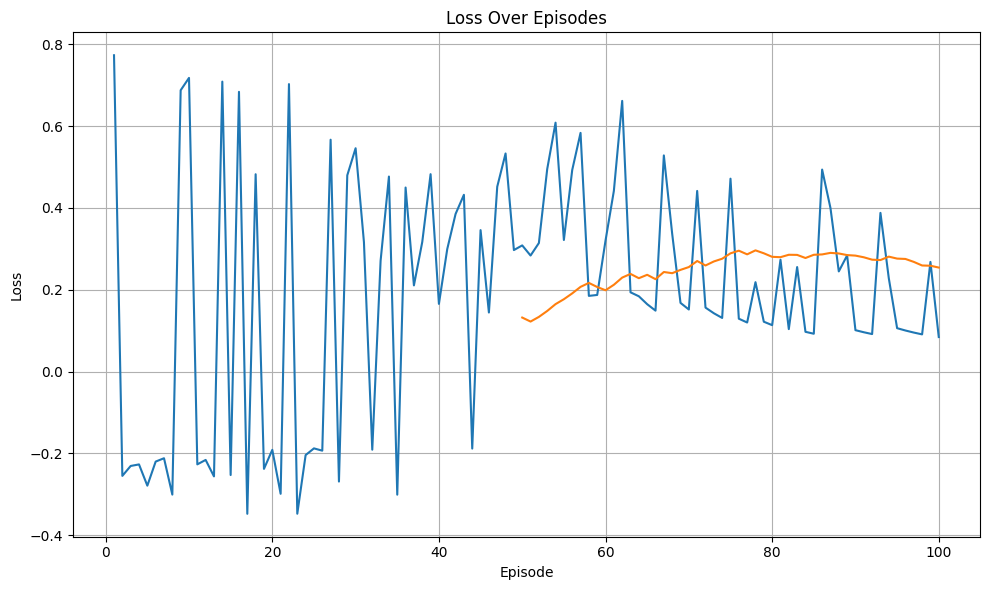

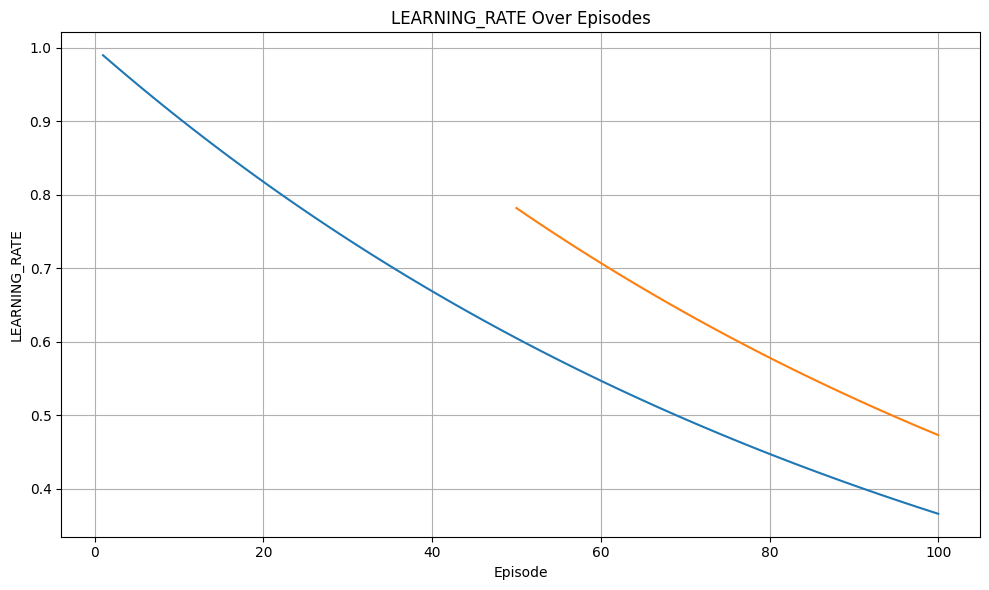

In [11]:
draw_history(rewards, "Reward")
draw_history(losses, "Loss")
draw_history(learning, "LEARNING_RATE")

**La linea naranja de la perdida a lo largo de los episodios es la funcion L que estamos intentando maximizar**

Para este experimento que hemos visto ahora, hemos fijado la semilla del generador de números aleatorios de `numpy` a 8. Tal como está planteado el problema, esta implementación debería poder resolver, eventualmente, cualquier semilla, pero con algunas tardará más, con otras menos, y con otras hará falta ajustar los parámetros del algoritmo. Hemos escogido 8 en este caso para poder ver un ejemplo con el que ir siguiendo la trayectoria con la UI y ver la convergencia de la política óptima en un tiempo razonable.

Vamos a ver una semilla que nos lo va a poner más difícil, `seed=0`. Vamos a probar con la misma configuración de parámetros. En este caso vamos a usar el entorno "rápido" para poder ejecutar más episodios rápidamente. **Probad con un número mayor de episodios para comprobar si consigue entrenar a partir de algún valor.**

In [ ]:
agent = ReinforceAgent(env_fast, gamma=GAMMA, learning_rate=LEARNING_RATE,
                       lr_decay=LEARNING_RATE_DECAY, seed=0)
rewards = []
losses = []
for i in range(TRAINING_EPISODES):
    reward, loss = agent.learn_from_episode()
    rewards.append(reward)
    losses.append(loss)
draw_history(rewards, "Reward")
draw_history(losses, "Loss")
print_policy(agent.policy()[0])

En este caso parece claro que no sólo van a hacer falta más iteraciones para converger. Seguramente los parámetros que estábamos usando no eran los mejores para el caso general.

**Encontrad una configuración de parámetros tal que puedas llegar a responder a las siguientes preguntas:**

* **¿A partir de qué punto obtenemos la política óptima?**
* **¿A partir de qué punto la política se estabiliza en prácticamente un 100% de probabilidad para la mejor acción de cada estado?**

**Para encontrar una configuración buena, intenta razonar qué parámetros hay que cambiar y en qué dirección, a partir de analizar cómo funciona el algoritmo y la función de pérdida.** A ciegas, es probable que os cueste considerablemente más.

**¿Qué ocurre si probáis otras semillas? ¿Es necesario seguir cambiando los parámetros para que el análisis se pueda hacer en general?**

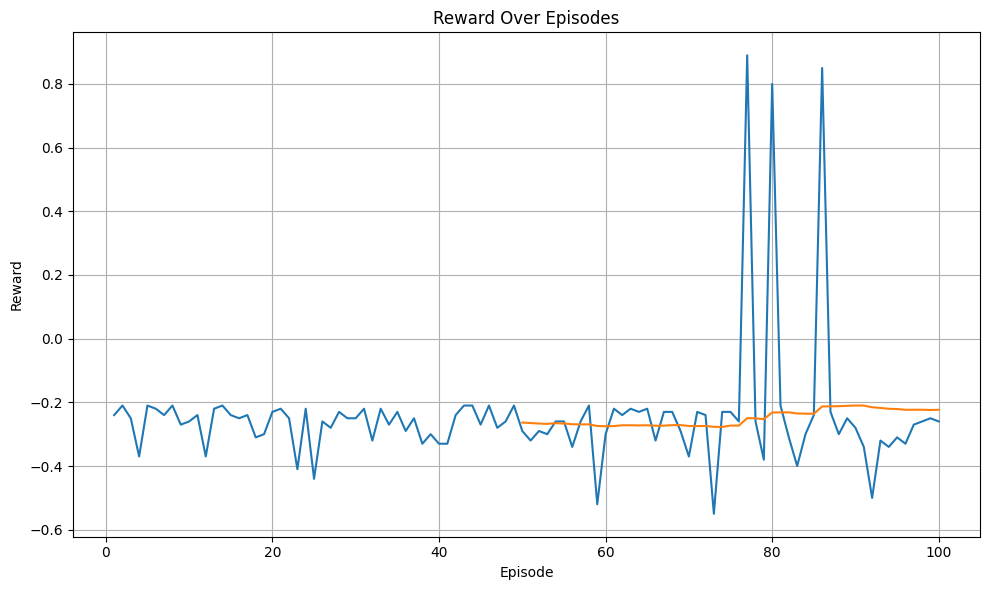

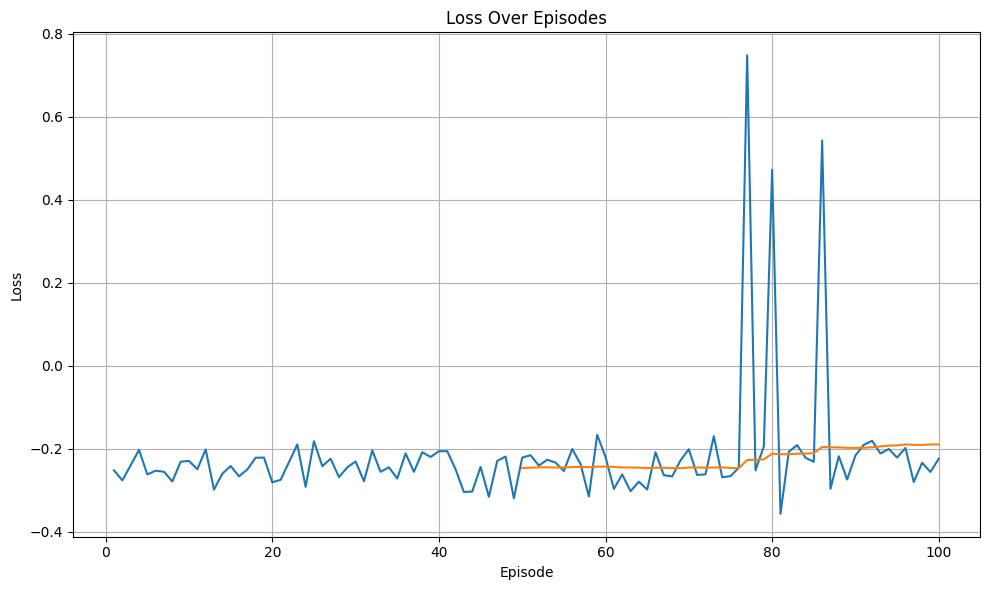

[['^' '>' '<' '>']
 ['v' '<' 'v' '<']
 ['>' 'v' 'v' '<']
 ['<' '>' '>' '<']]


In [19]:
agent = ReinforceAgent(env_fast, gamma=0.9, learning_rate=1.0,
                       lr_decay=0.99, seed=0)
rewards = []
losses = []
for i in range(100):
    reward, loss = agent.learn_from_episode()
    rewards.append(reward)
    losses.append(loss)
draw_history(rewards, "Reward")
draw_history(losses, "Loss")
print_policy(agent.policy()[0])

Hay un problema bastante importante con la politica, primero en el punto de incio vamos hacia arriba, pero aun peor en las dos casillas [1,2] y [1,3] tenemos un bucle infinito derecha e izquierda

Vamos a poner las cosas aún más complicadas, intentando entrenar el entorno con `slippery=True`. **Copia y parte de tus mejores parámetros del experimento anterior e intenta encontrar la manera de entrenar este entorno con el algoritmo REINFORCE.**

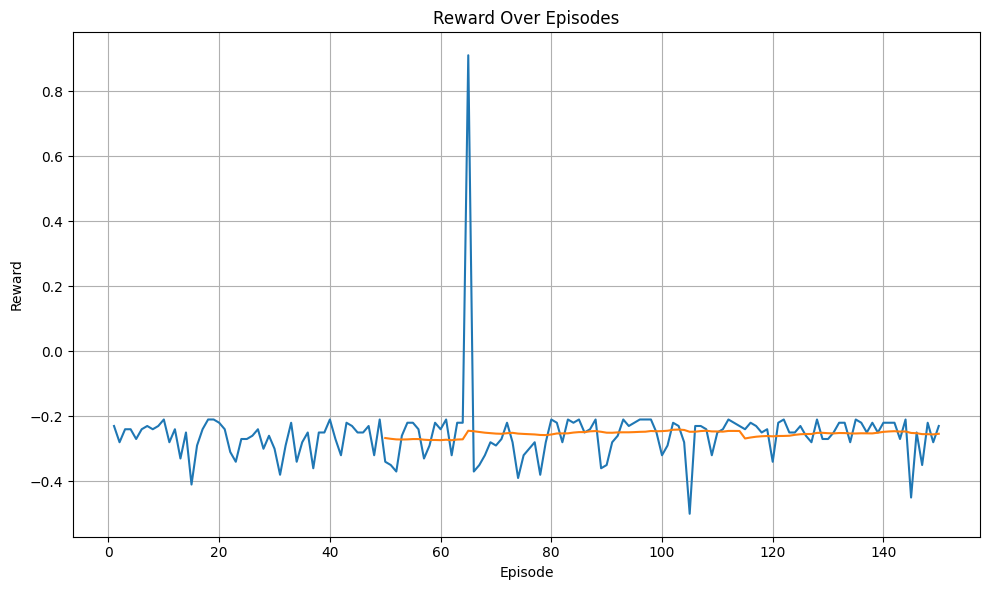

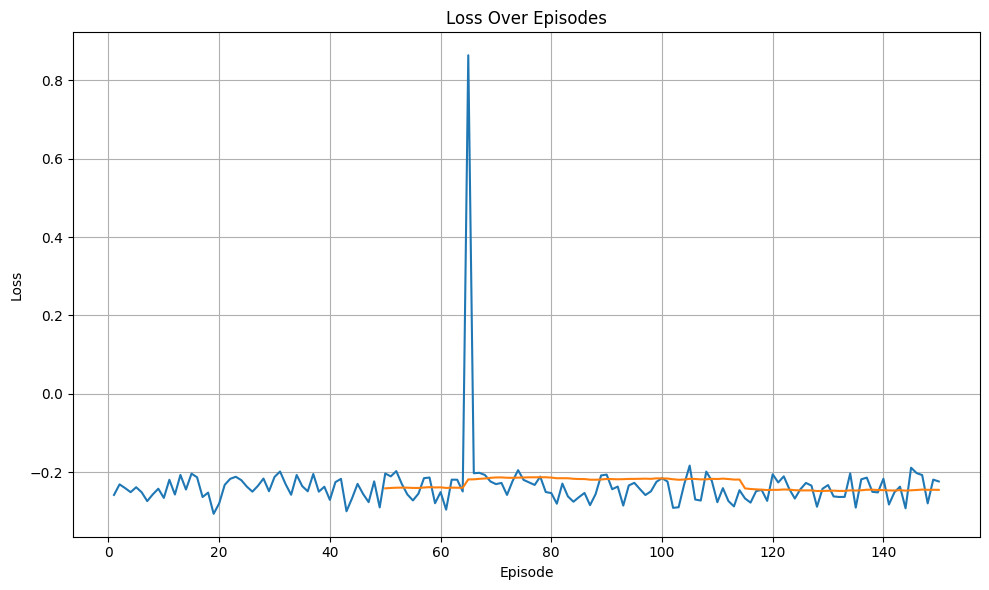

[['>' '<' '^' '^']
 ['^' '<' 'v' '<']
 ['^' '^' 'v' '<']
 ['<' '>' 'v' '<']]


In [25]:
env_slippery = CustomFrozenLakeWrapper(gym.make("FrozenLake-v1", desc=None, map_name="4x4",
                                                is_slippery=True))

agent = ReinforceAgent(env_slippery, gamma=0.9, learning_rate=1.0, lr_decay=0.99, seed=0)
rewards = []
losses = []
for i in range(150):
    reward, loss = agent.learn_from_episode()
    rewards.append(reward)
    losses.append(loss)
draw_history(rewards, "Reward")
draw_history(losses, "Loss")
print_policy(agent.policy()[0])

**¿Qué conclusiones podemos sacar de este experimento?**

Que no siempre tenemos la politica optima, por ejemplo en la casilla [1,0] decide que ^ es la mejor opcion cuando tendria que ser < ya que asi evitamos que este vaya a un lago